In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn

In [3]:
# Network parameters
nb_inputs  = 100
nb_hidden  = 4
nb_outputs = 2
time_step = 1e-3

# Training parameters
nb_steps  = 200
batch_size = 256
dtype = torch.float
device = torch.device("cpu")

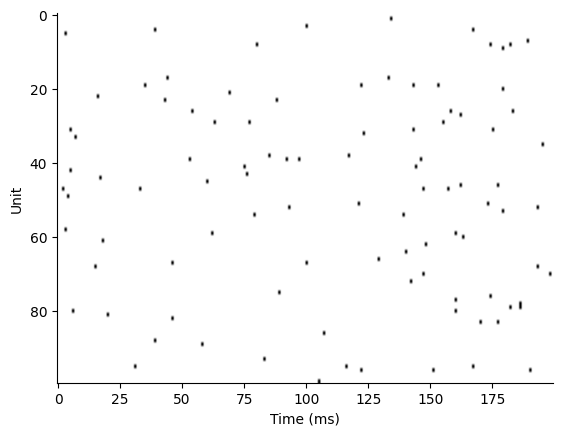

In [9]:
# Input spikes for development
freq = 5 # Hz
prob = freq*time_step
mask = torch.rand((batch_size,nb_steps,nb_inputs), device=device, dtype=dtype)
x_data = torch.zeros((batch_size,nb_steps,nb_inputs), device=device, dtype=dtype, requires_grad=False)
x_data[mask<prob] = 1.0

# Give random labels to each input pattern
y_data = torch.tensor(1*(np.random.rand(batch_size)<0.5), device=device)

data_id = 0
plt.imshow(x_data[data_id].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

In [112]:
# Setup the spiking network model
tau_mem = 10e-3  # Membrane voltage time constant
tau_syn = 5e-3  # Synaptic voltage time constant

# Decay constants for discretized equations
alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))


# Initialize the weight matrices
weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

# Input to hidden layer
w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

# Hidden layer to output layer
w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

# Recurrent connections
v = torch.empty((nb_hidden, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(v, mean=0.0, std=(weight_scale/np.sqrt(nb_hidden))/2)

print("init done")

init done


In [113]:
# x_data is batch_size x timesteps x inputs
# w1 is batch_size x timesteps x hidden neurons
h1 = torch.einsum("abc,cd->abd", (x_data, w1))

In [114]:
# Define the heaviside step function for the nonlinearity
def spike_fn(x):
    out = torch.zeros_like(x)
    out[x > 0] = 1.0
    return out

In [115]:
syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

# Here we define two lists which we use to record the membrane potentials and output spikes
mem_rec = []
spk_rec = []

# Here we loop over time
for t in range(nb_steps):
    mthr = mem-1.0
    out = spike_fn(mthr)
    rst = out.detach() # We do not want to backprop through the reset

    recurrent_input = torch.einsum("ab,bc->ac", (out, v))

    # Update the synaptic potentials 'batch_size x hidden neurons'
    new_syn = alpha*syn + h1[:,t] + recurrent_input

    # Update the membrane potentials 'batch_size x hidden neurons'
    new_mem = (beta*mem+syn)*(1.0-rst)
    
    mem_rec.append(mem)
    spk_rec.append(out)
    
    mem = new_mem
    syn = new_syn

# Now we merge the recorded membrane potentials into a single tensor
mem_rec = torch.stack(mem_rec,dim=1)
spk_rec = torch.stack(spk_rec,dim=1)

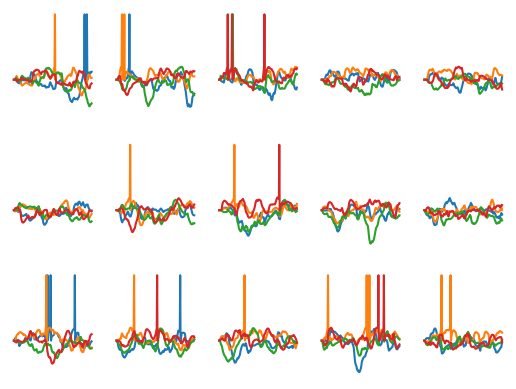

In [116]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)